In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import cv2
import os
import joblib
from numpy import asarray
from imageio.v3 import imread
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
import torch
from torch.utils.data import Dataset
from torchvision import transforms, utils
import pywt
from imblearn.combine import SMOTETomek
from imblearn.under_sampling import RandomUnderSampler
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report
import gc
from sklearn.metrics import confusion_matrix
from sklearn.svm import SVC
from xgboost import XGBClassifier

In [ ]:
def  image_segmentaion(img):


    img = np.float32(img)

    criteria = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 10, 1.0)
    K = 2
    ret,label,center=cv2.kmeans(img,K,None,criteria,10,cv2.KMEANS_RANDOM_CENTERS)

    center = np.uint8(center)
    colors = np.concatenate((center[0],center[1]),axis=None)

    col = 0 if np.mean(center[0]) > np.mean(center[1]) else 1
    res = center[label.flatten()]
    mask = res.reshape((img.shape))

    for i in range(len(mask)):
      for j in range(len(mask[i])):

        if mask[i][j][0] == center[col][0] and mask[i][j][1] == center[col][1] and mask[i][j][2] == center[col][2]: mask[i][j] = [0, 0, 0]
        else: mask[i][j] = [1, 1, 1]

    edges = cv2.Canny(mask,100,200)
    image = np.multiply(mask,img)

    return image,colors,edges

In [ ]:
def gaborfilter(img):

    ksize = 15
    sigma = 5
    theta = 1*np.pi/2
    lamda = 1*np.pi/4
    gamma=0.9
    phi = 0.8

    kernel = cv2.getGaborKernel((ksize, ksize), sigma, theta, lamda, gamma, phi, ktype=cv2.CV_32F)

    img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    fimg = cv2.filter2D(img, cv2.CV_8UC3, kernel)

    return fimg

In [ ]:
def wavelet_transform(img):
  LL, (image, HL, HH) = pywt.dwt2(img, 'bior1.3')
  return image

In [ ]:
metadata = pd.read_csv('/content/drive/MyDrive/PR dataset/HAM10000_metadata.csv')

In [ ]:
label_encoder = LabelEncoder()
metadata['dx_label'] = label_encoder.fit_transform(metadata['dx'])

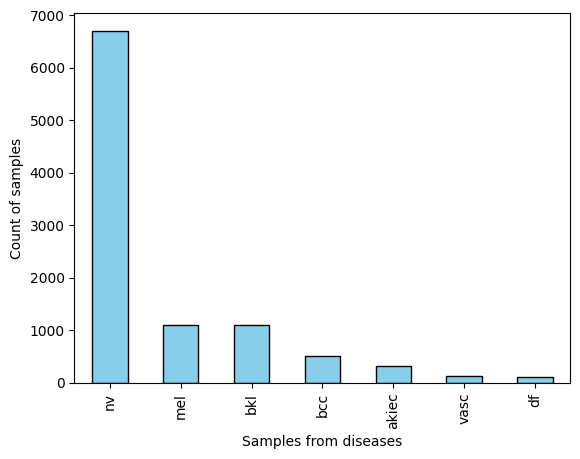

In [ ]:
label_counts = metadata['dx'].value_counts()
ax = label_counts.plot(kind='bar', color='skyblue', edgecolor='black')
ax.set_xlabel('Samples from diseases')
ax.set_ylabel('Count of samples')
plt.show()

In [ ]:
metadata.drop(labels=['lesion_id','dx_type','age','sex','localization'],axis=1,inplace=True)

In [ ]:
class_labels= {
    'nv': 'Melanocytic nevi',
    'mel': 'Melanoma',
    'bkl': 'Benign keratosis-like lesions',
    'bcc': 'Basal cell carcinoma',
    'akiec': 'Actinic keratoses and intraepithelial carcinoma',
    'vasc': 'Vascular lesions',
    'df': 'Dermatofibroma'
}

In [ ]:
X_training, X_testing, y_training, y_testing = train_test_split(metadata['image_id'],metadata['dx_label'],test_size = 0.2)

In [ ]:
class DatasetLoader(Dataset):

    def __init__(self, root_dir, mode, X, y):
        self.X = X
        self.y = y
        self.root_dir = root_dir
        self.mode = mode

    def __len__(self):
        return len(self.X)

    def __getitem__(self, i):
        disease = self.y.iloc[i]
        img_name = os.path.join(self.root_dir,
                                f"{self.X.iloc[i]}.jpg")
        image = imread(img_name)
        image,colors,edges = image_segmentaion(image)
        if self.mode==0:
          features = gaborfilter(image)
        if self.mode==1:
           features = wavelet_transform(image)
        if self.mode==2:
           features = edges

        sample = {'features': features.flatten(), 'color' : colors, 'disease': disease.astype(float)}
        return sample


Feature Extraction - Mode 0 (Texture Analysis)

In [ ]:
dataset = DatasetLoader(root_dir=r'/content/drive/MyDrive/PR dataset/Scaled_Images',mode=0,X=X_training,y=y_training)

In [ ]:
i=0
dataX=[]
datay=[]
for X in dataset:
  i+=1
  dataX.append(np.concatenate((X['features'],X['color']),axis=None))
  datay.append(X['disease'])
  if i%500==0:
    print(f'{i} samples read')

500 samples read
1000 samples read
1500 samples read
2000 samples read
2500 samples read
3000 samples read
3500 samples read
4000 samples read
4500 samples read
5000 samples read
5500 samples read
6000 samples read
6500 samples read
7000 samples read
7500 samples read
8000 samples read


In [ ]:
dataset = DatasetLoader(root_dir=r'/content/drive/MyDrive/PR dataset/Scaled_Images',mode=0,X=X_testing,y=y_testing)

In [ ]:
i=0
dataXtest=[]
dataytest=[]
for X in dataset:
  i+=1
  dataXtest.append(np.concatenate((X['features'],X['color']),axis=None))
  dataytest.append(X['disease'])
  if i%500==0:
    print(f'{i} samples read')

500 samples read
1000 samples read
1500 samples read
2000 samples read


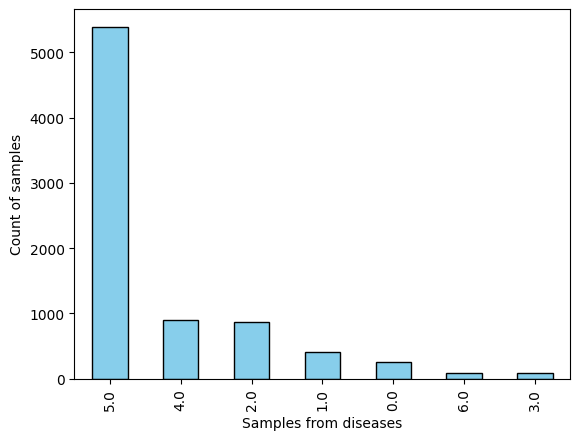

In [ ]:
label_counts = pd.Series(datay).value_counts()
ax = label_counts.plot(kind='bar', color='skyblue', edgecolor='black')
ax.set_xlabel('Samples from diseases')
ax.set_ylabel('Count of samples')
plt.show()

In [ ]:
smt = SMOTETomek()
X_train,y_train = smt.fit_resample(dataX,datay)

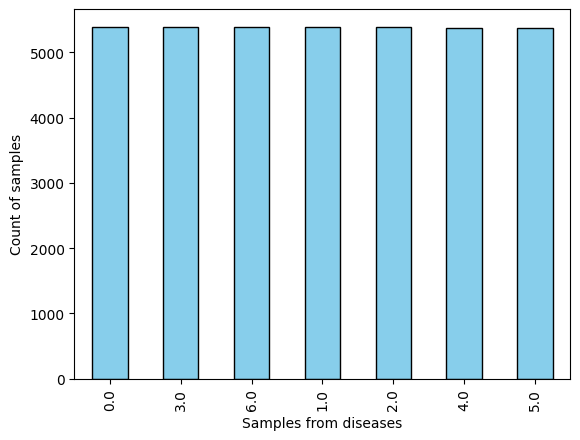

In [ ]:
label_counts = pd.Series(y_train).value_counts()
ax = label_counts.plot(kind='bar', color='skyblue', edgecolor='black')
ax.set_xlabel('Samples from diseases')
ax.set_ylabel('Count of samples')
plt.show()

In [ ]:
X_test,y_test = smt.fit_resample(dataXtest,dataytest)

In [ ]:
rfc = RandomForestClassifier(class_weight = 'balanced',random_state=42)
rfc.fit(X_train, y_train)

RandomForestClassifier(class_weight='balanced', random_state=42)

In [ ]:
y_pred = rfc.predict(X_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

         0.0       0.33      0.28      0.30      1311
         1.0       0.32      0.51      0.39      1311
         2.0       0.26      0.36      0.30      1310
         3.0       0.49      0.08      0.14      1311
         4.0       0.40      0.53      0.46      1308
         5.0       0.56      0.87      0.68      1306
         6.0       0.44      0.06      0.10      1310

    accuracy                           0.38      9167
   macro avg       0.40      0.38      0.34      9167
weighted avg       0.40      0.38      0.34      9167



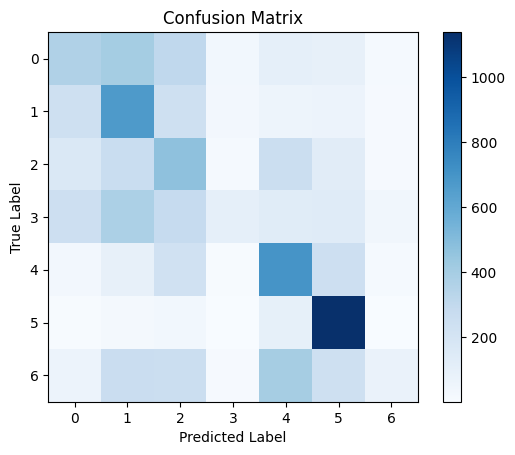

In [ ]:
conf_matrix = confusion_matrix(y_test, y_pred)
plt.imshow(conf_matrix, interpolation='nearest', cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.colorbar()
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

In [ ]:
svm_model = SVC(class_weight='balanced')

In [ ]:
svm_model.fit(X_train,y_train)

SVC(class_weight='balanced')

In [ ]:
y_pred = svm_model.predict(X_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

         0.0       0.27      0.18      0.22      1311
         1.0       0.28      0.42      0.33      1311
         2.0       0.23      0.39      0.29      1310
         3.0       0.33      0.04      0.07      1311
         4.0       0.38      0.50      0.44      1308
         5.0       0.64      0.92      0.75      1306
         6.0       0.60      0.15      0.23      1310

    accuracy                           0.37      9167
   macro avg       0.39      0.37      0.33      9167
weighted avg       0.39      0.37      0.33      9167



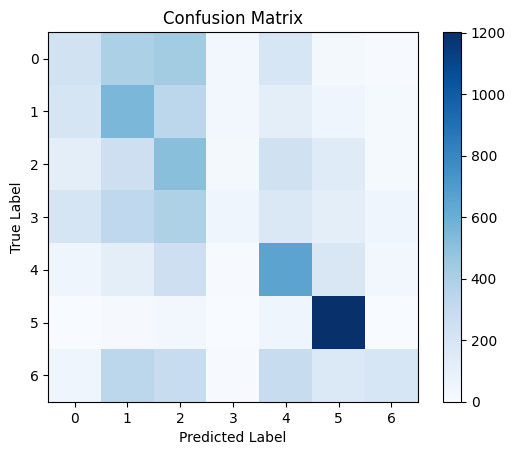

In [ ]:
conf_matrix = confusion_matrix(y_test, y_pred)
plt.imshow(conf_matrix, interpolation='nearest', cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.colorbar()
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

In [ ]:
from xgboost import XGBClassifier
xgbc = XGBClassifier()
xgbc.fit(X_train, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=None, n_jobs=None,
              num_parallel_tree=None, objective='multi:softprob', ...)

In [ ]:
y_pred = xgbc.predict(X_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

         0.0       0.33      0.18      0.23      1311
         1.0       0.32      0.53      0.40      1311
         2.0       0.24      0.42      0.31      1310
         3.0       0.43      0.08      0.13      1311
         4.0       0.43      0.52      0.47      1308
         5.0       0.61      0.92      0.74      1306
         6.0       0.69      0.11      0.20      1310

    accuracy                           0.39      9167
   macro avg       0.44      0.39      0.35      9167
weighted avg       0.44      0.39      0.35      9167



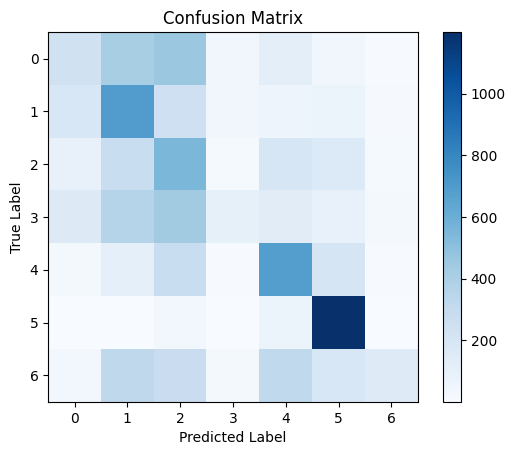

In [ ]:
conf_matrix = confusion_matrix(y_test, y_pred)
plt.imshow(conf_matrix, interpolation='nearest', cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.colorbar()
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

Feature Extraction - Mode 2 (Edges)

In [ ]:
dataset = DatasetLoader(root_dir=r'/content/drive/MyDrive/PR dataset/Scaled_Images',mode=2,X=X_training,y=y_training)

In [ ]:
i=0
dataX=[]
datay=[]
for X in dataset:
  i+=1
  # print(X["features"].shape)
  dataX.append(np.concatenate((X['features'],X['color']),axis=None))
  datay.append(X['disease'])
  if i%1000==0:
    print(f'{i} samples read')

1000 samples read
2000 samples read
3000 samples read
4000 samples read
5000 samples read
6000 samples read
7000 samples read
8000 samples read


In [ ]:
dataset = DatasetLoader(root_dir=r'/content/drive/MyDrive/PR dataset/Scaled_Images',mode=2,X=X_testing,y=y_testing)

In [ ]:
i=0
dataXtest=[]
dataytest=[]
for X in dataset:
  i+=1
  dataXtest.append(np.concatenate((X['features'],X['color']),axis=None))
  dataytest.append(X['disease'])
  if i%500==0:
    print(f'{i} samples read')

500 samples read
1000 samples read
1500 samples read
2000 samples read


In [ ]:
smt = SMOTETomek()
X_train,y_train = smt.fit_resample(dataX,datay)

In [ ]:
del dataX,datay
gc.collect()

30

In [ ]:
rfc = RandomForestClassifier(class_weight = 'balanced',random_state=42)
rfc.fit(X_train, y_train)

RandomForestClassifier(class_weight='balanced', random_state=42)

In [ ]:
X_test,y_test = smt.fit_resample(dataXtest,dataytest)

In [ ]:
del dataXtest,dataytest
gc.collect()

0

In [ ]:
y_pred = rfc.predict(X_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

         0.0       0.28      0.33      0.30      1353
         1.0       0.28      0.37      0.32      1353
         2.0       0.28      0.32      0.30      1339
         3.0       0.32      0.09      0.14      1359
         4.0       0.32      0.41      0.36      1339
         5.0       0.61      0.82      0.70      1323
         6.0       0.59      0.26      0.37      1355

    accuracy                           0.37      9421
   macro avg       0.38      0.37      0.35      9421
weighted avg       0.38      0.37      0.35      9421



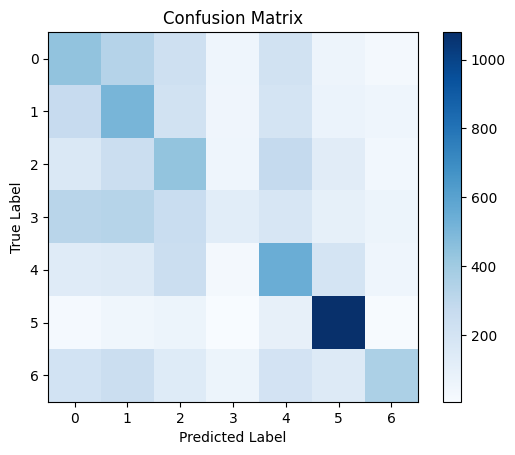

In [ ]:
conf_matrix = confusion_matrix(y_test, y_pred)
plt.imshow(conf_matrix, interpolation='nearest', cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.colorbar()
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

In [ ]:
svm_model = SVC(class_weight='balanced')
svm_model.fit(X_train,y_train)

SVC(class_weight='balanced')

In [ ]:
y_pred = svm_model.predict(X_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

         0.0       0.26      0.24      0.25      1353
         1.0       0.26      0.25      0.25      1353
         2.0       0.22      0.33      0.27      1339
         3.0       0.20      0.08      0.12      1359
         4.0       0.28      0.31      0.29      1339
         5.0       0.52      0.70      0.60      1323
         6.0       0.38      0.31      0.34      1355

    accuracy                           0.31      9421
   macro avg       0.30      0.32      0.30      9421
weighted avg       0.30      0.31      0.30      9421



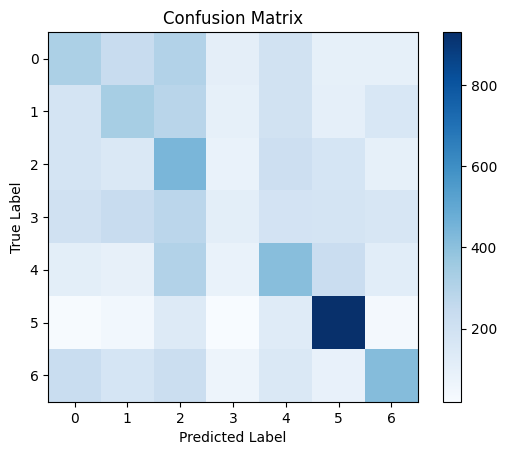

In [ ]:
conf_matrix = confusion_matrix(y_test, y_pred)
plt.imshow(conf_matrix, interpolation='nearest', cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.colorbar()
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

In [ ]:
xgbc = XGBClassifier()
xgbc.fit(X_train, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=None, n_jobs=None,
              num_parallel_tree=None, objective='multi:softprob', ...)

In [ ]:
y_pred = xgbc.predict(X_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

         0.0       0.32      0.30      0.31      1353
         1.0       0.28      0.38      0.33      1353
         2.0       0.29      0.39      0.33      1339
         3.0       0.35      0.08      0.13      1359
         4.0       0.35      0.45      0.39      1339
         5.0       0.66      0.83      0.73      1323
         6.0       0.77      0.44      0.56      1355

    accuracy                           0.41      9421
   macro avg       0.43      0.41      0.40      9421
weighted avg       0.43      0.41      0.40      9421



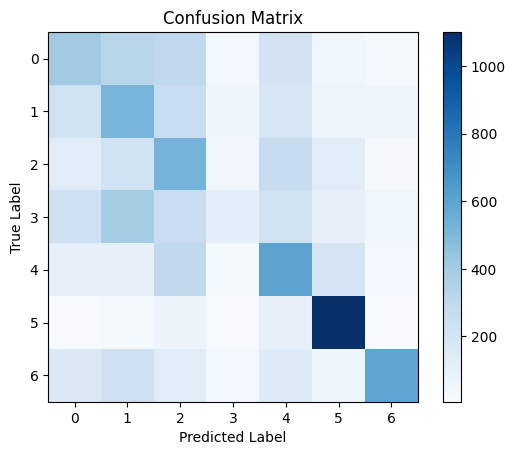

In [ ]:
conf_matrix = confusion_matrix(y_test, y_pred)
plt.imshow(conf_matrix, interpolation='nearest', cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.colorbar()
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

Features Extraction - Mode 1 (Wavelet Transform)

```
Note : Using SMOTETomek for wavelet transform requires more RAM than Colab associated
```



In [ ]:
dataset = DatasetLoader(root_dir=r'/content/drive/MyDrive/PR dataset/Scaled_Images',mode=1,X=X_training,y=y_training)

In [ ]:
i=0
dataX=[]
datay=[]
for X in dataset:
  i+=1
  dataX.append(np.concatenate((X['features'],X['color']),axis=None))
  datay.append(X['disease'])
  if i%1000==0:
    print(f'{i} samples read')

1000 samples read
2000 samples read
3000 samples read
4000 samples read
5000 samples read
6000 samples read
7000 samples read
8000 samples read


In [ ]:
smt = SMOTETomek()
X_train,y_train = smt.fit_resample(dataX,datay)

In [ ]:
rfc = RandomForestClassifier(class_weight = 'balanced',random_state=42)
rfc.fit(X_train, y_train)

RandomForestClassifier(class_weight='balanced', random_state=42)

In [ ]:
dataset = DatasetLoader(root_dir=r'/content/drive/MyDrive/PR dataset/Scaled_Images',mode=1,X=X_testing,y=y_testing)

In [ ]:
i=0
dataXtest=[]
dataytest=[]
for X in dataset:
  i+=1
  dataXtest.append(np.concatenate((X['features'],X['color']),axis=None))
  dataytest.append(X['disease'])
  if i%500==0:
    print(f'{i} samples read')

500 samples read
1000 samples read
1500 samples read
2000 samples read
2500 samples read
3000 samples read
3500 samples read
4000 samples read
4500 samples read
5000 samples read


In [ ]:
X_test,y_test = smt.fit_resample(dataXtest,dataytest)

In [ ]:
y_pred = rfc.predict(X_test)
print(classification_report(y_test, y_pred))

In [ ]:
conf_matrix = confusion_matrix(y_test, y_pred)
plt.imshow(conf_matrix, interpolation='nearest', cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.colorbar()
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

In [ ]:
svm_model = SVC(class_weight='balanced')
svm_model.fit(X_train,y_train)

In [ ]:
y_pred = svm_model.predict(X_test)
print(classification_report(y_test, y_pred))

In [ ]:
conf_matrix = confusion_matrix(y_test, y_pred)
plt.imshow(conf_matrix, interpolation='nearest', cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.colorbar()
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

In [ ]:
xgbc = XGBClassifier()
xgbc.fit(X_train, y_train)

In [ ]:
y_pred = xgbc.predict(X_test)
print(classification_report(y_test, y_pred))

In [ ]:
conf_matrix = confusion_matrix(y_test, y_pred)
plt.imshow(conf_matrix, interpolation='nearest', cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.colorbar()
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()